# Latent Dirichlet Allocation

In [120]:
#Text Processing libraries
import nltk; nltk.download('stopwords'); nltk.download('punkt'); nltk.download('wordnet'); nltk.download('averaged_perceptron_tagger')
import re
from nltk.corpus import stopwords
import unicodedata

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [121]:
#Load-data Libraries
import pandas as pd
import spacy
#loading tiny corpus
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
#cachedStopWords = nlp.Defaults.stop_words

In [122]:
STOPWORD = nltk.corpus.stopwords.words('english')
STOPWORD.extend([ 'first', 'second', 'third', 'me', 'haha', 'lol', 'oof', 'cds', 'll', 've'])

In [123]:
data = pd.read_csv('data', sep=",", header=None)

data.columns = ['text']

data.head()

text
0  From: gld@cunixb.cc.columbia.edu (Gary L Dare)...
1  From: atterlep@vela.acs.oakland.edu (Cardinal ...
2  From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...
3  From: atterlep@vela.acs.oakland.edu (Cardinal ...
4  From: vzhivov@superior.carleton.ca (Vladimir Z...

The data is a collection of emails that are not labelled. Let's try extract topics from them!

## Preprocessing 

👇 You're used to it by now... Clean up! Store the cleaned text in a new dataframe column "clean_text".

# . NLP:  prepocessing

In [124]:
def delete_accentchar(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x
def lema(x):
    """lemmatize"""
    
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    return (" ".join(x_list))
#regex module,
def remove_num(clean_text):
    # remove numbers
    clean_textnonum = re.sub(r'\d+', '', clean_text)
    return clean_textnonum

In [125]:
data['clean_text'] =  data['text'].apply(lambda x: x.lower().strip())
data['clean_text'] = data['clean_text'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))
data['clean_text'] = data['clean_text'].apply(lambda x: " ".join(x.split()))
#data['clean_text'] = data['clean_text'].apply(lambda x: re.split(r'\W+', x))
#data['clean_text'] = data['text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]"," ",x.lower().strip()))
data['clean_text'] = data['clean_text'].apply(lambda x: delete_accentchar(x))
data['clean_text'] = data['clean_text'].apply(lambda x: " ".join([w for w in x.split() if w not in STOPWORD]))
data['clean_text'] = data['clean_text'].apply(lambda x: lema(x))
data['clean_text']=data['clean_text'].apply(lambda x: remove_num(x))

In [126]:
data.head()

text  \
0  From: gld@cunixb.cc.columbia.edu (Gary L Dare)...   
1  From: atterlep@vela.acs.oakland.edu (Cardinal ...   
2  From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...   
3  From: atterlep@vela.acs.oakland.edu (Cardinal ...   
4  From: vzhivov@superior.carleton.ca (Vladimir Z...   

                                          clean_text  
0  gldcunixbcccolumbiaedu gary l daresubject stan...  
1  atterlepvelaacsoaklandedu cardinal ximenezsubj...  
2  minerkuhubccukansedusubject ancient booksorgan...  
3  atterlepvelaacsoaklandedu cardinal ximenezsubj...  
4  vzhivovsuperiorcarletonca vladimir zhivovsubje...

In [127]:
#drop the text column
data = data.drop(['text'],axis=1)
data.columns = ["clean_text"]
data.head()

clean_text
0  gldcunixbcccolumbiaedu gary l daresubject stan...
1  atterlepvelaacsoaklandedu cardinal ximenezsubj...
2  minerkuhubccukansedusubject ancient booksorgan...
3  atterlepvelaacsoaklandedu cardinal ximenezsubj...
4  vzhivovsuperiorcarletonca vladimir zhivovsubje...

In [128]:
#checking for misssing. no missing ...
data.isna().sum()

clean_text    0
dtype: int64

Vectorizing: to convert the string data to numeric. I use Count vectorizer as the Latent Drichlet Allocation model has TD-IDF built in, hence I use Count vectorizer to avoid bad output.

In [129]:
#Vectorization:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
def get_bow(df,d,range_min,range_max,mindf,maxdf):
    
    tfidf = TfidfVectorizer()
    text_counts = tfidf.fit_transform(data['clean_text'])
    cv_df = pd.DataFrame(text_counts.toarray(), columns = tfidf.get_feature_names())#bow
    return tfidf,cv_df

In [130]:
tfidf = TfidfVectorizer()
text_counts = tfidf.fit_transform(data['clean_text'])

In [131]:
text_counts.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [132]:
tfidf.idf_

array([6.70378247, 7.39692966, 7.39692966, ..., 7.39692966, 7.39692966,
       7.39692966])

In [133]:
tvectorizer,data_cv = get_bow(data,'clean_text',3,4,5,0.5)

## Latent Dirichlet Allocation model

👇 Train an LDA model to extract potential topics.

In [134]:
#model libraries modules
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [135]:
n_topics = 12
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
model_lda.fit_transform(text_counts)

array([[0.39077273, 0.2069248 , 0.00708987, ..., 0.00708962, 0.00708955,
        0.00708948],
       [0.57924258, 0.14173412, 0.00727052, ..., 0.08884036, 0.00727048,
        0.00727045],
       [0.72914008, 0.00675483, 0.00675468, ..., 0.00675475, 0.00675474,
        0.00675489],
       ...,
       [0.91170315, 0.00802701, 0.00802698, ..., 0.00802698, 0.00802698,
        0.00802698],
       [0.01440462, 0.35141243, 0.01440387, ..., 0.01440412, 0.01440441,
        0.01440387],
       [0.77280543, 0.00925147, 0.00925145, ..., 0.00925166, 0.00925145,
        0.00925145]])

In [136]:
'''
For each topic, we investigate the words occurrence  in the topic and their relative weight
'''
# Print the top 12 words per topic
n_words = 12
feature_names = tvectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    print([(feature_names[i], topic[i].round(3)) for i in topic.argsort()[:-n_words -1:-1]])
    
    """top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx} \nwords: {top_features}".format(topic_idx, topic))
    print('\n\n\n')"""

[('god', 32.074), ('not', 30.581), ('would', 22.628), ('do', 21.268), ('say', 20.958), ('one', 20.62), ('people', 19.408), ('know', 18.726), ('think', 18.383), ('go', 17.9), ('jesus', 16.433), ('believe', 15.815)]
[('game', 18.278), ('player', 14.308), ('play', 13.225), ('team', 11.653), ('hockey', 10.268), ('goal', 8.689), ('leafs', 8.57), ('wing', 7.346), ('win', 7.329), ('toronto', 6.877), ('vs', 6.654), ('espn', 6.405)]
[('octopus', 1.309), ('proof', 1.125), ('terrance', 0.981), ('adirondack', 0.931), ('secretary', 0.917), ('watt', 0.911), ('suhonen', 0.877), ('generation', 0.874), ('dlmqccunyvmbitnet', 0.829), ('dab', 0.824), ('heathathenacsugaedu', 0.819), ('cape', 0.79)]
[('todd', 1.15), ('poll', 1.031), ('tiebreakerorganization', 0.784), ('willfutonwebodgcom', 0.784), ('partial', 0.772), ('ulf', 0.758), ('ra', 0.74), ('rich', 0.708), ('defensemen', 0.707), ('atnjd', 0.679), ('chef', 0.679), ('andexcellent', 0.679)]
[('georgia', 4.037), ('intelligence', 1.929), ('ai', 1.829), ('

## Visualize potential topics

👇 The function to print the words associated with the potential topics is already made for you. You just have to pass the correct arguments!

In [137]:
# Used LDA to look for 12 topics
n_topics = 12
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
model_lda.fit(data_cv)

# Print the top 10 words per topic
n_words = 10
feature_names = tvectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    top_n = [feature_names[i]
              for i in topic.argsort()
               [-n_words:]][::-1]
    
    top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}:\nwords: {top_features}".format(topic_idx, topic))
    print('\n\n\n')
    
topic_result = model_lda.transform(data_cv)
data['topic']  = topic_result.argmax(axis=1)

Topic 0:
words: god not would do say one people know think go




Topic 1:
words: game player play team hockey goal leafs wing win toronto




Topic 2:
words: octopus proof terrance adirondack secretary watt suhonen generation dlmqccunyvmbitnet dab




Topic 3:
words: todd poll tiebreakerorganization willfutonwebodgcom partial ulf ra rich defensemen atnjd




Topic 4:
words: georgia intelligence ai ntmi athens mcovingtaiugaedu artificial amateur programs covingtonsubject




Topic 5:
words: cell canon reidcsuiucedu plymouth prophecy grogersslacvxslacstanfordedu sspx stanford cyt rturgeoozplymouthedu




Topic 6:
words: ttt legal chant sexual masterson foolish tounge maygenevarutgersedu melbourne gamespick




Topic 7:
words: fisher universitylines homosexuality realiability scofield act the salvation federko salami




Topic 8:
words: ahl pts disappointment huotcraycom jagr valerie tomb third kill tin




Topic 9:
words: absolute chi gtdaprismgatechedu europeans idacom pitt hrivnak dea

In [138]:
def top_n_gram(corpus,r, n=None):
    vec = CountVectorizer(ngram_range=(r, r), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [139]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [140]:
common_words = top_n_gram(data['clean_text'], 1, 50)

tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 unigrams');

plt.savefig('output.png', dpi=300)


<Figure size 432x288 with 0 Axes>

In [141]:
#biagram
common_words = top_n_gram(data['clean_text'], 2, 50)

tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 bigrams');
plt.savefig('2gram.pdf')                                                                         

<Figure size 432x288 with 0 Axes>

In [142]:
#trigram
common_words = top_n_gram(data['clean_text'], 3, 50)

tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 trigrams');

In [143]:
#4grams
common_words = top_n_gram(data['clean_text'], 4, 50)
    
tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 4-grams')

Observation:most of the word revolve around sport, education and religion

In [145]:
topic

array([0.08333333, 0.08333333, 0.08333333, ..., 0.08333333, 0.08333333,
       0.25729443])

In [146]:
   
topic_result = model_lda.transform(data_cv)
data['topic']  = topic_result.argmax(axis=1)

In [147]:
#plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud



A look at the wordcloud of all the topics to get a better idea of which topic given by the LDA suits best with the offered topic

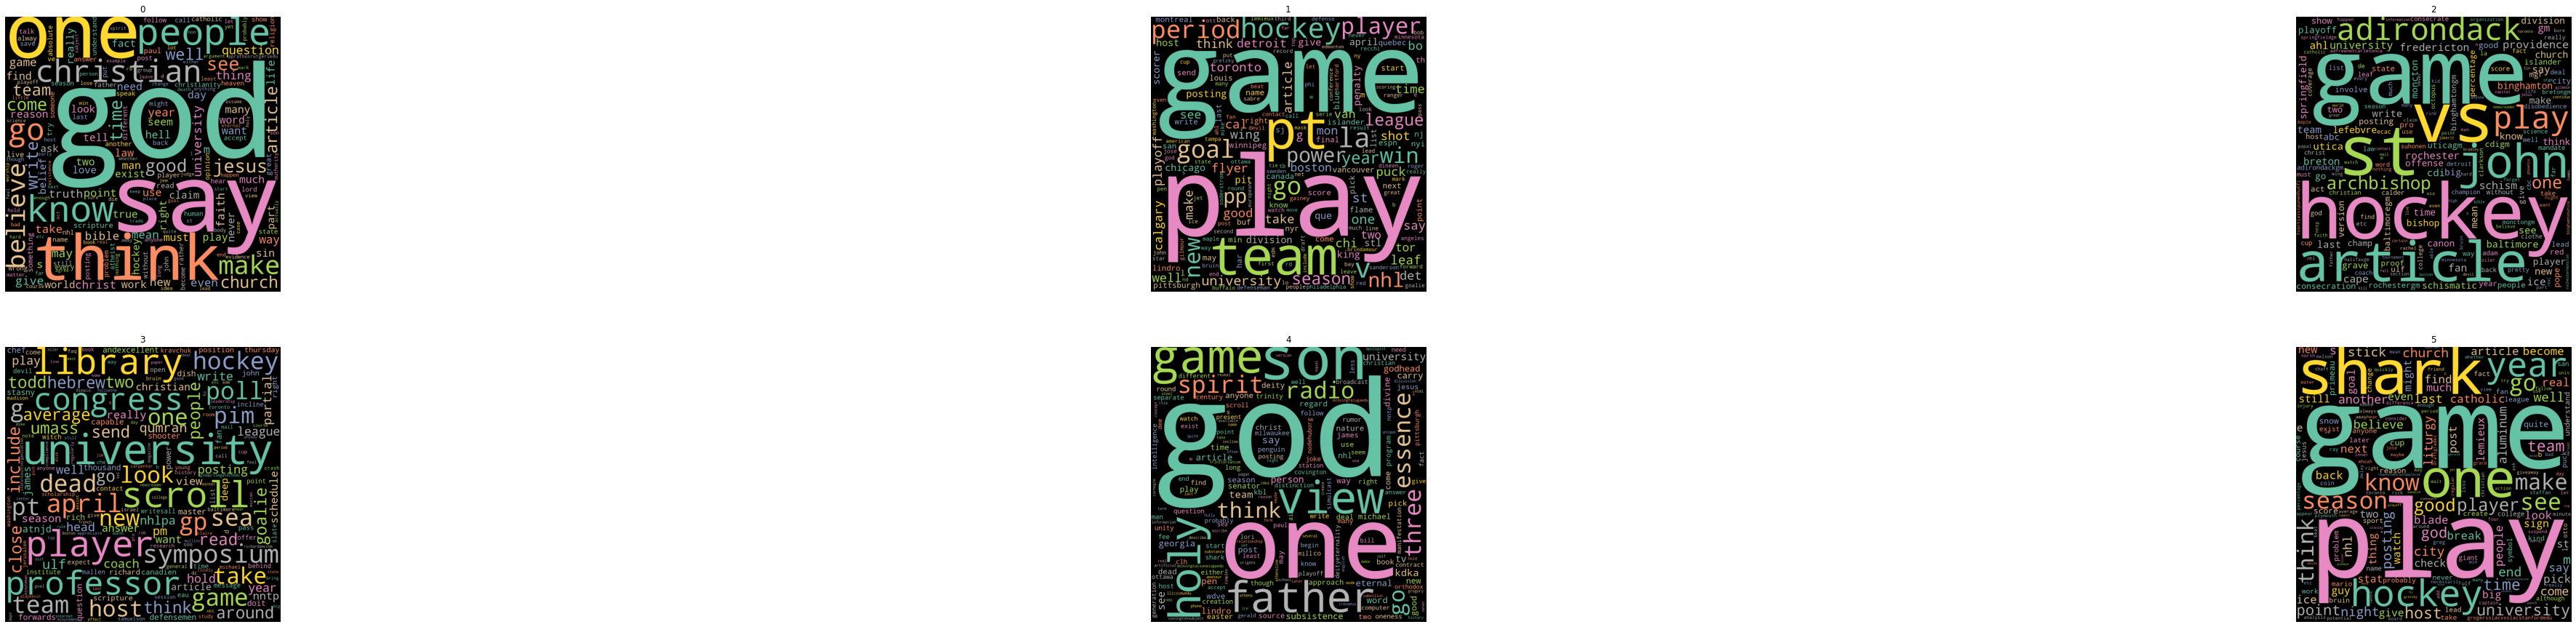

In [148]:
fig = plt.figure(figsize=(80,32))
for i in range(6):
    ax = fig.add_subplot(4,3,i+1)
    topic = i
    text = ' '.join(data.loc[data['topic']==i,'clean_text'].values)
    wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)
    ax.imshow(wc)
    ax.set_title(topic)
    ax.axis("off");

Next we observe which topics are distributed in which way, this is vital as we have to build a classifier based on this

In [149]:
data.groupby('topic').count()['clean_text'].iplot(kind='bar', 
                                              yTitle='Count', 
                                              linecolor='black', 
                                              opacity=0.8,
                                              title='Bar chart of Topic Name',
                                              xTitle='Topic Name')

## Predict topic of new text

👇 You can now use your LDA model to predict the topic of a new text. First, use your vectorizer to vectorize the example. Then, use your LDA model to predict the topic of the vectorized example.

In [150]:
#encoding
df=data[['clean_text','topic']]
df = pd.get_dummies(df, columns=['topic'])

In [151]:
df

clean_text  topic_0  topic_1  \
0     gldcunixbcccolumbiaedu gary l daresubject stan...        1        0   
1     atterlepvelaacsoaklandedu cardinal ximenezsubj...        1        0   
2     minerkuhubccukansedusubject ancient booksorgan...        1        0   
3     atterlepvelaacsoaklandedu cardinal ximenezsubj...        1        0   
4     vzhivovsuperiorcarletonca vladimir zhivovsubje...        0        0   
...                                                 ...      ...      ...   
1194  jerrybeskimocom jerry kaufmansubject prayer ad...        0        0   
1195  golchowyalchemychemutorontoca gerald olchowysu...        0        0   
1196  jaynemmaltguildorg jayne kulikauskassubject qu...        1        0   
1197  sclarkepasutorontoca susan clarksubject pick f...        0        0   
1198  lmvecwestminsteracuk william hargreavessubject...        1        0   

      topic_2  topic_3  topic_4  topic_5  topic_6  topic_7  topic_8  topic_9  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        0        0        0        1        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1194        0        0        0        0        0        0        0        0   
1195        1        0        0        0        0        0        0        0   
1196        0        0        0        0        0        0        0        0   
1197        0        0        0        0        0        1        0        0   
1198        0        0        0        0        0        0        0        0   

      topic_10  topic_11  
0            0         0  
1            0         0  
2            0         0  
3            0         0  
4            0         0  
...        ...       ...  
1194         0         1  
1195         0         0  
1196         0         0  
1197         0         0  
1198         0         0  

[1199 rows x 13 columns]

In [152]:
df['count']=df['clean_text'].apply(lambda x: len(str(x).split()))

In [153]:
#splitting the data
TRAIN, TEST = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

x_train = TRAIN.clean_text
x_test = TEST.clean_text

#print the shape

print(x_train.shape)
print(x_test.shape)

(803,)
(396,)


In [154]:
import sklearn
print(sklearn.__version__)

0.24.2


In [155]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.multiclass import OneVsRestClassifier
# Define a pipeline combining a text feature extractor with multi lable classifier
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=STOPWORD)),
                ('smote', SMOTE(random_state=12)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),])


In [156]:
classes = ['topic_0', 
              'topic_1',
              'topic_2', 
              'topic_3', 
              'topic_4', 
              'topic_5',
              'topic_6',
              'topic_7',
              'topic_8',
              'topic_9',
              'topic_10',
              'topic_11']

In [157]:
#evaluating the model
#accuracy, precision, recall
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
for category in classes:
    print('... preprocessing {}'.format(category))

    pipeline.fit(x_train, TRAIN[category])#train pipeline

    prediction = pipeline.predict(x_test)#testing the pipeline using trained model
    accuracy = accuracy_score(TEST[category], prediction)
    print('Test accuracy in percentage is:', round(accuracy, 2)*100)

    

... preprocessing topic_0
Test accuracy in percentage is: 77.0
... preprocessing topic_1
Test accuracy in percentage is: 69.0
... preprocessing topic_2
Test accuracy in percentage is: 93.0
... preprocessing topic_3
Test accuracy in percentage is: 98.0
... preprocessing topic_4
Test accuracy in percentage is: 96.0
... preprocessing topic_5
Test accuracy in percentage is: 95.0
... preprocessing topic_6
Test accuracy in percentage is: 97.0
... preprocessing topic_7
Test accuracy in percentage is: 95.0
... preprocessing topic_8
Test accuracy in percentage is: 84.0
... preprocessing topic_9
Test accuracy in percentage is: 89.0
... preprocessing topic_10
Test accuracy in percentage is: 93.0
... preprocessing topic_11
Test accuracy in percentage is: 96.0


In [158]:
print("Other Metrics:")
print(classification_report(TEST[category], prediction))


Other Metrics:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       384
           1       0.36      0.33      0.35        12

    accuracy                           0.96       396
   macro avg       0.67      0.66      0.66       396
weighted avg       0.96      0.96      0.96       396



In [159]:
#
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

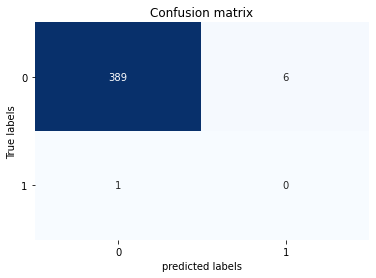

In [83]:
## Plot confusion matrix
from sklearn.metrics import confusion_matrix
classes = np.unique(TEST[category])

cm = confusion_matrix(TEST[category], prediction)
fig, ax = plt.subplots()

sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="predicted labels", ylabel="True labels", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

Observation:We can see that we have 6 False negative and 0 True Negative. While True Positive = 389 and False Positive = 1 which is not bad. Our accuracy seems not to be bad

In [160]:
#save the model
import pickle

file_name = 'Npipelinemodel'
pickle.dump(pipeline, open(file_name, 'wb'))

In [161]:
data1=df[['clean_text']]

In [162]:
data1.head()

clean_text
0  gldcunixbcccolumbiaedu gary l daresubject stan...
1  atterlepvelaacsoaklandedu cardinal ximenezsubj...
2  minerkuhubccukansedusubject ancient booksorgan...
3  atterlepvelaacsoaklandedu cardinal ximenezsubj...
4  vzhivovsuperiorcarletonca vladimir zhivovsubje...

# Azure cognitive

In [163]:
from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials
# Import necessary libraries
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [164]:
# Define the service key and endpoint of Azure Text Analytics
cog_key = '068af73f1cfc40dd844c73421b251c63'
cog_endpoint = 'https://azurecognitiveservices-badewa.cognitiveservices.azure.com/'

print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))

Ready to use cognitive services at https://azurecognitiveservices-badewa.cognitiveservices.azure.com/ using key 068af73f1cfc40dd844c73421b251c63


In [165]:
from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials
# Import necessary libraries
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
def authenticate_client():
    ta_credential = AzureKeyCredential(cog_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=cog_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [166]:
data1['count']=data1['clean_text'].apply(lambda x: len(str(x).split()))

In [167]:
data1['char_count']=df['clean_text'].apply(lambda x: len(x))

In [168]:
data1

clean_text  count  char_count
0     gldcunixbcccolumbiaedu gary l daresubject stan...    149        1081
1     atterlepvelaacsoaklandedu cardinal ximenezsubj...    175        1329
2     minerkuhubccukansedusubject ancient booksorgan...    195        1527
3     atterlepvelaacsoaklandedu cardinal ximenezsubj...    109         807
4     vzhivovsuperiorcarletonca vladimir zhivovsubje...    149        1028
...                                                 ...    ...         ...
1194  jerrybeskimocom jerry kaufmansubject prayer ad...     75         543
1195  golchowyalchemychemutorontoca gerald olchowysu...     52         483
1196  jaynemmaltguildorg jayne kulikauskassubject qu...    169        1191
1197  sclarkepasutorontoca susan clarksubject pick f...     32         247
1198  lmvecwestminsteracuk william hargreavessubject...     91         611

[1199 rows x 3 columns]

In [169]:
data1[data1.char_count > 1000]

clean_text  count  char_count
0     gldcunixbcccolumbiaedu gary l daresubject stan...    149        1081
1     atterlepvelaacsoaklandedu cardinal ximenezsubj...    175        1329
2     minerkuhubccukansedusubject ancient booksorgan...    195        1527
4     vzhivovsuperiorcarletonca vladimir zhivovsubje...    149        1028
8     randolinpolisciumnedu robert andolinasubject m...    233        1635
...                                                 ...    ...         ...
1188  andrewidacomhpcom andrew scottsubject usenet h...    632        4157
1189  norrisathenamitedu richard chonaksubject athei...    226        1711
1192  jsleddssdcsasupennedu james sleddsubject proof...    126        1043
1193  jpcphilabsphilipscom john p curciosubject abcs...    195        1338
1196  jaynemmaltguildorg jayne kulikauskassubject qu...    169        1191

[522 rows x 3 columns]

In [170]:
indexNames = data1[data1['char_count'] > 1000].index

In [171]:
data1.drop(indexNames , inplace=True)

In [172]:
data1

clean_text  count  char_count
3     atterlepvelaacsoaklandedu cardinal ximenezsubj...    109         807
5     hudsonathenacsugaedu paul hudson jrsubject hel...     44         349
6     jcjtellabscom jcjsubject proof resurectionorga...     57         455
7     mandtbackafinaboabofi mats andtbackasubject he...     97         781
9     adavismclbdmcom arthur davissubject ron franci...     91         698
...                                                 ...    ...         ...
1191  swartzjhrosevcrose - hulmanedusubject espn ton...     53         366
1194  jerrybeskimocom jerry kaufmansubject prayer ad...     75         543
1195  golchowyalchemychemutorontoca gerald olchowysu...     52         483
1197  sclarkepasutorontoca susan clarksubject pick f...     32         247
1198  lmvecwestminsteracuk william hargreavessubject...     91         611

[677 rows x 3 columns]

In [173]:
data2=data1[['clean_text']]
data2

clean_text
3     atterlepvelaacsoaklandedu cardinal ximenezsubj...
5     hudsonathenacsugaedu paul hudson jrsubject hel...
6     jcjtellabscom jcjsubject proof resurectionorga...
7     mandtbackafinaboabofi mats andtbackasubject he...
9     adavismclbdmcom arthur davissubject ron franci...
...                                                 ...
1191  swartzjhrosevcrose - hulmanedusubject espn ton...
1194  jerrybeskimocom jerry kaufmansubject prayer ad...
1195  golchowyalchemychemutorontoca gerald olchowysu...
1197  sclarkepasutorontoca susan clarksubject pick f...
1198  lmvecwestminsteracuk william hargreavessubject...

[677 rows x 1 columns]

We dropped all documents above 1000 documents due to limitations wrt stockage

In [175]:
# Configure Azure Text Analytics client-library
text_sentiment = []
key_phrase_extract = []

# Pass text content to Azure Text Analytics and collect sentiment output
for index, headers in data2.iterrows():
    clean_text_content = str(headers['clean_text'])
    print("clean Text Content: {}".format(clean_text_content))
    documents = [clean_text_content]
    response = client.analyze_sentiment(documents=documents, show_opinion_mining=True, language="en")[0]
    sentiment = response.sentiment
    print("clean Text Content Sentiment: {}".format(sentiment))
    response_ekp = client.extract_key_phrases(documents = documents)[0]
    for phrase in response_ekp.key_phrases:
                #print("Key phrase: {}".format(phrase))
                key_phrase_extract.append(phrase)
                print(key_phrase_extract)
    
    text_sentiment.append([clean_text_content, sentiment, key_phrase_extract])
    
    key_phrase_extract = []

    # Convert collected text content with sentiment to Pandas dfs.
text_sentiment = pd.DataFrame(text_sentiment, columns=['clean_text','sentiment',
                                                                                 'key_phrase_extract'])


clean Text Content: atterlepvelaacsoaklandedu cardinal ximenezsubject atheist hellorganization national association disorganizedline  hello see two common thread run posting atheist newsgroup think use explain unfortunately do not direct quote handy atheist believe die die forever god would condemn fail believe eternal death unfair do not see problem christians hell definition eternal death -- exactly atheist expect die there s noreason hell especially awful -- to people eternal death badenough literal interpreter bible problem view sincethe bible talk fire hell personally do not thinkthat people hell thrust flame expect jesuswith double - edge sword issue mouth -- I treat statementsas metaphoricalalan terlep scorpion say oakland university rochester miin natureatterlepvelaacsoaklandedurushe angel fear tread -- jody
clean Text Content Sentiment: negative
['atterlepvelaacsoaklandedu cardinal ximenezsubject atheist hellorganization national association']
['atterlepvelaacsoaklandedu cardi

In [176]:
text_sentiment

clean_text sentiment  \
0    atterlepvelaacsoaklandedu cardinal ximenezsubj...  negative   
1    hudsonathenacsugaedu paul hudson jrsubject hel...  negative   
2    jcjtellabscom jcjsubject proof resurectionorga...  positive   
3    mandtbackafinaboabofi mats andtbackasubject he...  negative   
4    adavismclbdmcom arthur davissubject ron franci...  positive   
..                                                 ...       ...   
672  swartzjhrosevcrose - hulmanedusubject espn ton...   neutral   
673  jerrybeskimocom jerry kaufmansubject prayer ad...  positive   
674  golchowyalchemychemutorontoca gerald olchowysu...  positive   
675  sclarkepasutorontoca susan clarksubject pick f...   neutral   
676  lmvecwestminsteracuk william hargreavessubject...  negative   

                                    key_phrase_extract  
0    [atterlepvelaacsoaklandedu cardinal ximenezsub...  
1    [article aprgenevarutgersedu jprzybylskidmoree...  
2    [jcjsubject proof resurectionorganization, sco...  
3    [imnsho-- successful terrorism call revolution...  
4    [host jupitermclbdmcomin article aprvirginiaed...  
..                                                 ...  
672  [hulman institute technologyline reply, tampa ...  
673  [devine intervention realization brother, kauf...  
674  [keyword leaf wingsorganization university tor...  
675  [san jose goalsthan sen, fan ottawa daigle esw...  
676  [lmvecwestminsteracuk william hargreavessubjec...  

[677 rows x 3 columns]